
**Target** : 
1.   Add DropOut to avoid overfitting


**Results** : 
1.   Parameters: 7,852
2.   Best Training accuracy: 99.08%
1.   Best Testing accuracy: 99.11%

**Analysis**:
1.  Model is now not overfitting
2.  There is scope for increasing the capacity of the model with more layers







In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


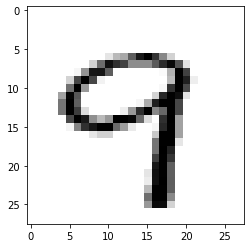

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

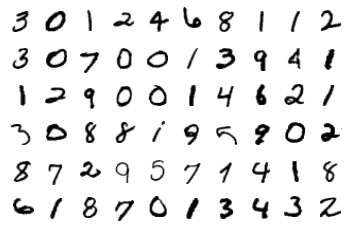

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
dropout = 0.07
class MNISTNet(nn.Module):

  def __init__(self):
    super(MNISTNet, self).__init__()
    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(dropout)
    ) # output_size = 28

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 26

    # TRANSITION BLOCK 1
    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

    # CONVOLUTION BLOCK 1
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 11

    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(dropout)
    ) # output_size = 9
    
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=14, kernel_size=(1, 1), padding=0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout(dropout)
    ) # output_size = 9

    
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout(dropout)
    ) # output_size = 7

    # OUTPUT BLOCK
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    ) # output_size = 1

    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0,  bias = False),
      ) # output_size = 1


  def forward(self, x):
    
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
         MaxPool2d-9           [-1, 16, 13, 13]               0
           Conv2d-10           [-1, 16, 11, 11]           2,304
             ReLU-11           [-1, 16, 11, 11]               0
      BatchNorm2d-12           [-1, 16, 11, 11]              32
          Dropout-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.08515400439500809 Batch_id=468 Accuracy=85.12: 100%|██████████| 469/469 [00:10<00:00, 43.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1061, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


Loss=0.1497185379266739 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:10<00:00, 44.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9770/10000 (97.70%)

EPOCH: 2


Loss=0.049742575734853745 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:10<00:00, 44.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.1435609608888626 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:10<00:00, 43.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.13030658662319183 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:10<00:00, 44.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9801/10000 (98.01%)

EPOCH: 5


Loss=0.01896463707089424 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 44.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9868/10000 (98.68%)

EPOCH: 6


Loss=0.026809267699718475 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9860/10000 (98.60%)

EPOCH: 7


Loss=0.05014003440737724 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:10<00:00, 44.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.06584753841161728 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:11<00:00, 42.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.04465865716338158 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:10<00:00, 45.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9893/10000 (98.93%)

EPOCH: 10


Loss=0.08892610669136047 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:10<00:00, 44.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


Loss=0.08064358681440353 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:10<00:00, 44.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.013322834856808186 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 44.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.0022926144301891327 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 44.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.08853111416101456 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.53it/s]



Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)



Text(0.5, 1.0, 'Test Accuracy')

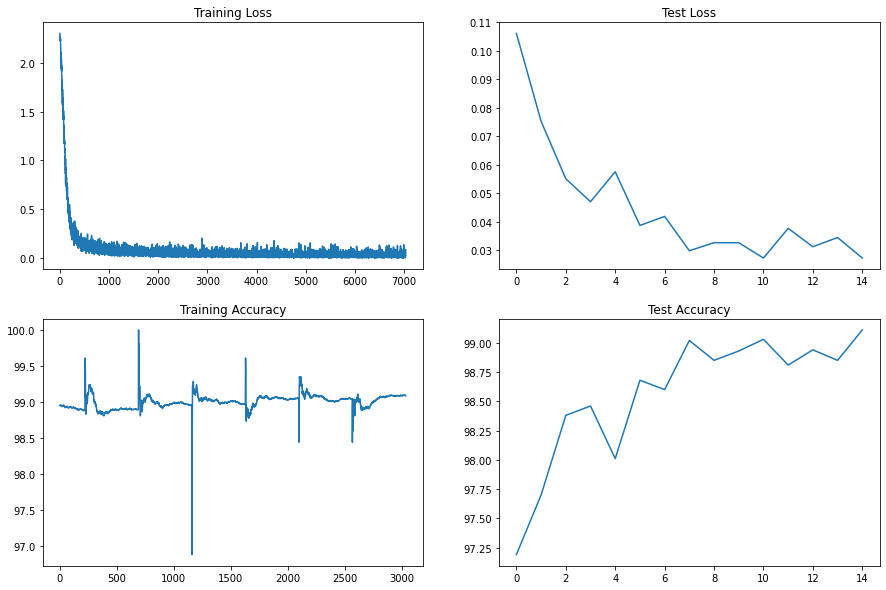

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")